In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('obesity_data_with_status_50000.csv')

In [22]:
label_encoder = LabelEncoder()
df['Obesity_Status'] = label_encoder.fit_transform(df['Obesity_Status'])
df['Blood_Pressure'] = label_encoder.fit_transform(df['Blood_Pressure'])

def remove_outliers_zscore(df, column_names, threshold=3):
    z_scores = np.abs((df[column_names] - df[column_names].mean()) / df[column_names].std())
    filtered_df = df[(z_scores < threshold).all(axis=1)]
    return filtered_df

continuous_columns = ['Height_cm', 'Weight_kg']
df_cleaned = remove_outliers_zscore(df, continuous_columns)

In [21]:
scaler = StandardScaler()
df_cleaned[['Height_cm', 'Weight_kg']] = scaler.fit_transform(df_cleaned[['Height_cm', 'Weight_kg']])

In [11]:
from sklearn.model_selection import train_test_split

# Feature-Target Split
X = df_cleaned.drop('Obesity_Status', axis=1)
y = df_cleaned['Obesity_Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39795, 15), (9949, 15), (39795,), (9949,))

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")

Logistic Regression Accuracy: 0.8962709820082421


In [26]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")

Random Forest Accuracy: 1.0


In [27]:
# SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}")

SVM Accuracy: 0.9981907729420042


In [28]:
# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")

XGBoost Accuracy: 0.9974871846416725


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def focal_loss(gamma=2., alpha=4.):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    return focal_loss_fixed

In [31]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=4.), metrics=['accuracy'])

# Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(X_train, tf.keras.utils.to_categorical(y_train, num_classes=4),
                    epochs=50, batch_size=32,
                    validation_data=(X_test, tf.keras.utils.to_categorical(y_test, num_classes=4)),
                    callbacks=[early_stopping, lr_reduction])

Epoch 1/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3983 - loss: 1.6946 - val_accuracy: 0.8104 - val_loss: 0.1912 - learning_rate: 0.0010
Epoch 2/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7331 - loss: 0.2050 - val_accuracy: 0.9009 - val_loss: 0.0818 - learning_rate: 0.0010
Epoch 3/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8294 - loss: 0.1127 - val_accuracy: 0.9565 - val_loss: 0.0407 - learning_rate: 0.0010
Epoch 4/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8730 - loss: 0.0845 - val_accuracy: 0.9492 - val_loss: 0.0355 - learning_rate: 0.0010
Epoch 5/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8937 - loss: 0.0703 - val_accuracy: 0.9605 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 6/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9055 - loss: 0.0629 - val_accuracy: 0.9511 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 7/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9162 -

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,694 (123.81 KB)

 Trainable params: 10,564 (41.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,130 (82.54 KB)

In [17]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.0 MB/s eta 0:00:00


In [32]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score

tabnet_model = TabNetClassifier()

tabnet_model.fit(X_train.values, y_train.values,
                 max_epochs=100,
                 patience=10,
                 batch_size=1024,
                 virtual_batch_size=128,
                 num_workers=0,
                 drop_last=False)

y_pred_tabnet = tabnet_model.predict(X_test.values)

print(f"TabNet Accuracy: {accuracy_score(y_test, y_pred_tabnet)}")

epoch 0  | loss: 0.9369  |  0:00:01s
epoch 1  | loss: 0.23586 |  0:00:03s
epoch 2  | loss: 0.16815 |  0:00:05s
epoch 3  | loss: 0.18545 |  0:00:07s
epoch 4  | loss: 0.14111 |  0:00:08s
epoch 5  | loss: 0.13546 |  0:00:10s
epoch 6  | loss: 0.13685 |  0:00:11s
epoch 7  | loss: 0.13193 |  0:00:13s
epoch 8  | loss: 0.1192  |  0:00:14s
epoch 9  | loss: 0.12176 |  0:00:17s
epoch 10 | loss: 0.13287 |  0:00:18s
epoch 11 | loss: 0.11713 |  0:00:20s
epoch 12 | loss: 0.10921 |  0:00:21s
epoch 13 | loss: 0.12401 |  0:00:23s
epoch 14 | loss: 0.11624 |  0:00:24s
epoch 15 | loss: 0.12079 |  0:00:26s
epoch 16 | loss: 0.13533 |  0:00:28s
epoch 17 | loss: 0.10477 |  0:00:30s
epoch 18 | loss: 0.11522 |  0:00:32s
epoch 19 | loss: 0.09552 |  0:00:33s
epoch 20 | loss: 0.09913 |  0:00:35s
epoch 21 | loss: 0.10336 |  0:00:36s
epoch 22 | loss: 0.11379 |  0:00:38s
epoch 23 | loss: 0.09909 |  0:00:40s
epoch 24 | loss: 0.10058 |  0:00:42s
epoch 25 | loss: 0.09714 |  0:00:43s
epoch 26 | loss: 0.09299 |  0:00:45s
e

311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Model Comparison:
                     Accuracy
Logistic Regression  0.896271
Random Forest        1.000000
SVM                  0.998191
XGBoost              0.997487
Deep Learning Model  0.992462
TabNet               0.993768


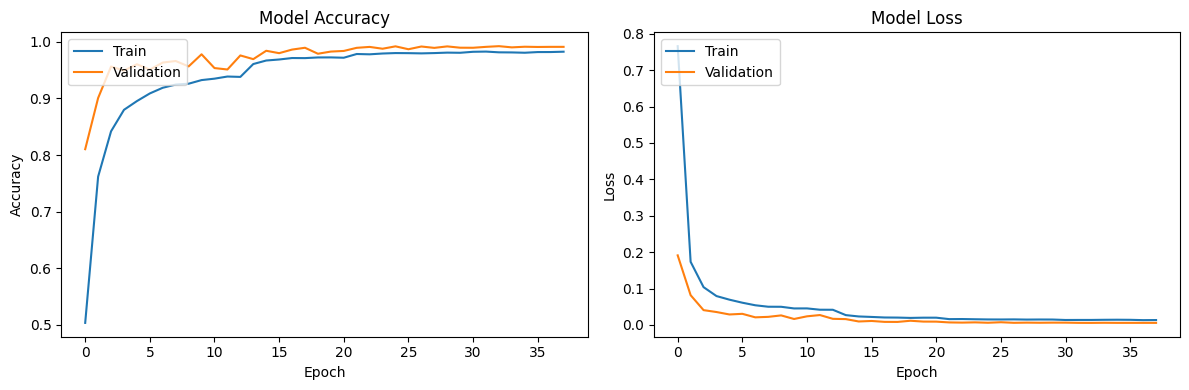

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

model_results = {
    'Logistic Regression': accuracy_score(y_test, y_pred_log_reg),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'SVM': accuracy_score(y_test, y_pred_svm),
    'XGBoost': accuracy_score(y_test, y_pred_xgb),
    'Deep Learning Model': accuracy_score(y_test, np.argmax(model.predict(X_test), axis=1)),
    'TabNet': accuracy_score(y_test, y_pred_tabnet)
}

results_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['Accuracy'])
print("Model Comparison:")
print(results_df)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()